# My Neural Network Library

In [7]:
import numpy as np

class Layer:
    """Base class for all layers in the neural network."""
    def forward(self, input_data):
        """Computes the forward pass."""
        raise NotImplementedError
    
    def backward(self, grad_output):
        """Computes the backward pass."""
        raise NotImplementedError

class LinearLayer(Layer):
    """Fully connected linear layer."""
    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.weights = np.random.randn(output_dim, input_dim) * np.sqrt(2 / input_dim)
        self.bias = np.zeros((output_dim, 1))

    def forward(self, input_data):
        """Performs forward pass: output = input * weights^T + bias"""
        self.input_data = input_data  # Store for use in backward pass
        return np.dot(self.weights, input_data.T).T + self.bias.T

    def backward(self, grad_output, learning_rate=0.01):
        """Computes gradients and updates parameters."""
        grad_input = np.dot(grad_output, self.weights)  # dL/dX
        grad_weights = np.dot(grad_output.T, self.input_data)  # dL/dW
        grad_bias = np.sum(grad_output, axis=0, keepdims=True).T  # dL/db
        
        # Update weights and biases
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias
        
        return grad_input
    
class Sigmoid(Layer):
    """Sigmoid activation function."""
    def forward(self, input_data):
        self.output = 1 / (1 + np.exp(-input_data))
        return self.output
    
    def backward(self, grad_output):
        return grad_output * self.output * (1 - self.output)
    
class Tanh(Layer):
    """Tanh activation function."""
    def forward(self, input_data):
        self.output = np.tanh(input_data)
        return self.output
    
    def backward(self, grad_output):
        return grad_output * (1 - self.output ** 2)
    
class ReLU(Layer):
    """ReLU activation function."""
    def forward(self, input_data):
        self.input_data = input_data
        return np.maximum(0, input_data)
    
    def backward(self, grad_output):
        return grad_output * (self.input_data > 0)

class BinaryCrossEntropyLoss(Layer):
    """Binary Cross-Entropy Loss Function."""
    def forward(self, predictions, targets):
        self.predictions = np.clip(predictions, 1e-12, 1 - 1e-12)  # Avoid log(0)
        self.targets = targets
        return -np.mean(targets * np.log(self.predictions) + (1 - targets) * np.log(1 - self.predictions))
    
    def backward(self):
        return (self.predictions - self.targets) / (self.targets.shape[0])

class MeanSquaredErrorLoss(Layer):
    """Mean Squared Error Loss Function."""
    def forward(self, predictions, targets):
        self.predictions = predictions
        self.targets = targets
        # Ensure both predictions and targets have the same shape
        assert predictions.shape == targets.shape, "Shapes of predictions and targets do not match"
        return np.mean((predictions - targets) ** 2)  # Element-wise squared error

    def backward(self):
        # Compute the gradient of the loss with respect to predictions
        return 2 * (self.predictions - self.targets) / self.predictions.size

class Sequential(Layer):
    """Sequential model to stack multiple layers."""
    def __init__(self):
        self.layers = []
    
    def add(self, layer):
        """Adds a new layer to the model."""
        self.layers.append(layer)
    
    def forward(self, input_data):
        """Performs a forward pass through all layers."""
        for layer in self.layers:
            input_data = layer.forward(input_data)
        return input_data
    
    def backward(self, grad_output, learning_rate=0.01):
        """Performs a backward pass through all layers."""
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate) if isinstance(layer, LinearLayer) else layer.backward(grad_output)
    
    def save_weights(self, filename):
        """Saves model weights to a file."""
        weights = [layer.weights for layer in self.layers if isinstance(layer, LinearLayer)]
        biases = [layer.bias for layer in self.layers if isinstance(layer, LinearLayer)]
        np.savez(filename, *weights, *biases)
    
    def load_weights(self, filename):
        """Loads model weights from a file while ensuring correct indexing."""
        data = np.load(filename)
        keys = sorted(data.files)  # Ensure we get them in the right order
        num_linear_layers = sum(1 for layer in self.layers if isinstance(layer, LinearLayer))

        weight_keys = keys[:num_linear_layers]
        bias_keys = keys[num_linear_layers:]

        linear_layers = [layer for layer in self.layers if isinstance(layer, LinearLayer)]

        for layer, w_key, b_key in zip(linear_layers, weight_keys, bias_keys):
            layer.weights = data[w_key]
            layer.bias = data[b_key]



# Testing Library Against XOR Problem

In [8]:
# XOR Problem Setup
np.random.seed(0)
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = np.array([[0], [1], [1], [0]])

# Define the model
model = Sequential()
model.add(LinearLayer(2, 2))  # Hidden layer with 2 neurons
model.add(Tanh())
model.add(LinearLayer(2, 1))  # Output layer
model.add(Tanh())

# Training
epochs = 10000
learning_rate = 0.1
loss_function = BinaryCrossEntropyLoss()

for epoch in range(epochs):
    # Forward pass
    predictions = model.forward(X)
    loss = loss_function.forward(predictions, y)
    
    # Backward pass
    grad_output = loss_function.backward()
    model.backward(grad_output, learning_rate)
    
    # Print loss every 1000 epochs
    if epoch % 1000 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Save trained model weights
model.save_weights("XOR_solved")

# Test the model
predictions = model.forward(X)
print("Final Predictions:")
print(predictions)

Epoch 0, Loss: 7.2639
Epoch 1000, Loss: 0.3836
Epoch 2000, Loss: 0.0517
Epoch 3000, Loss: 0.0263
Epoch 4000, Loss: 0.0193
Epoch 5000, Loss: 0.0158
Epoch 6000, Loss: 0.0136
Epoch 7000, Loss: 0.0121
Epoch 8000, Loss: 0.0110
Epoch 9000, Loss: 0.0101
Final Predictions:
[[4.67735818e-04]
 [9.82337554e-01]
 [9.81713307e-01]
 [9.25608756e-04]]


## XOR Problem Results

Looks like using the tanh activations got the right predictions, couldn't get it to work well with sigmoid activations.

# New York Data Set

https://drive.google.com/file/d/1xEtmFpP-WwZ-GC0B2njySPoLmdOCJOYM/view

Epoch 0, Loss: 38.2597, Val Loss: 38.0793
Saving model at epoch 0 with loss 38.2597
Epoch 1, Loss: 26.0203, Val Loss: 25.0553
Saving model at epoch 1 with loss 26.0203
Epoch 2, Loss: 16.4768, Val Loss: 12.9767
Saving model at epoch 2 with loss 16.4768
Epoch 3, Loss: 14.0858, Val Loss: 8.2482
Saving model at epoch 3 with loss 14.0858
Epoch 4, Loss: 13.8391, Val Loss: 7.3441
Saving model at epoch 4 with loss 13.8391
Epoch 5, Loss: 13.2379, Val Loss: 6.8126
Saving model at epoch 5 with loss 13.2379
Epoch 6, Loss: 12.7026, Val Loss: 6.3674
Saving model at epoch 6 with loss 12.7026
Epoch 7, Loss: 12.2228, Val Loss: 5.9721
Saving model at epoch 7 with loss 12.2228
Epoch 8, Loss: 11.8100, Val Loss: 5.6410
Saving model at epoch 8 with loss 11.8100
Epoch 9, Loss: 11.4058, Val Loss: 5.3510
Saving model at epoch 9 with loss 11.4058
Epoch 10, Loss: 11.0568, Val Loss: 5.0966
Saving model at epoch 10 with loss 11.0568
Epoch 11, Loss: 10.7217, Val Loss: 4.8722
Saving model at epoch 11 with loss 10.72

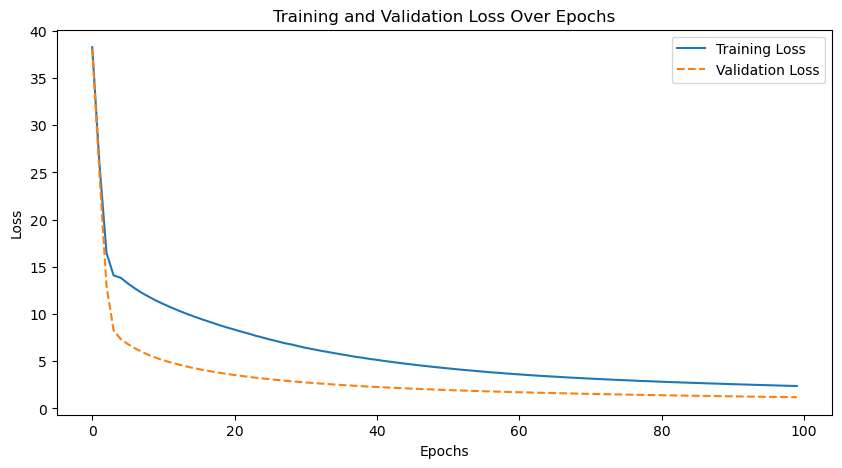

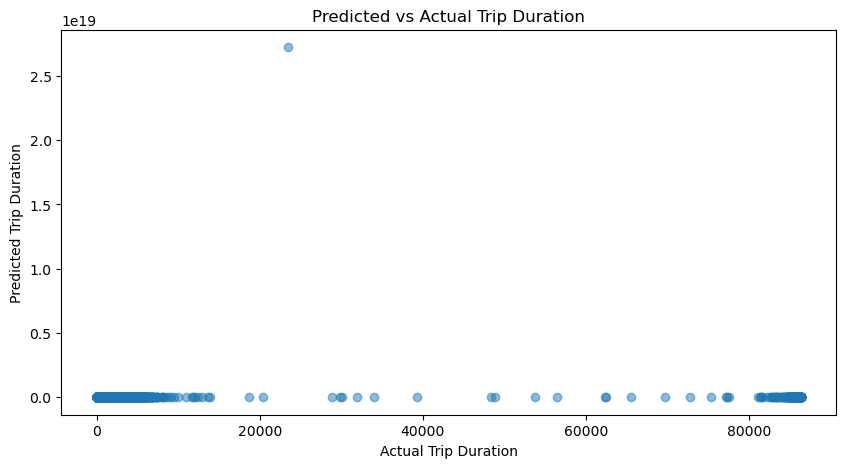

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from geopy.distance import great_circle

def haversine_distance(lat1, lon1, lat2, lon2):
    return great_circle((lat1, lon1), (lat2, lon2)).km

# Load dataset
np.random.seed(0)
dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train = dataset["X_train"], dataset["y_train"]
X_test, y_test = dataset["X_test"], dataset["y_test"]

df_train = pd.DataFrame(X_train, columns=["vendor_id", "pickup_datetime", "passenger_count",
                                          "pickup_longitude", "pickup_latitude",
                                          "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag"])
df_train["trip_duration"] = y_train
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"])
df_train["hour"] = df_train["pickup_datetime"].dt.hour
df_train["day_of_week"] = df_train["pickup_datetime"].dt.dayofweek
df_train["month"] = df_train["pickup_datetime"].dt.month
df_train["haversine_distance"] = df_train.apply(lambda row: 
    haversine_distance(row["pickup_latitude"], row["pickup_longitude"], 
                       row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
df_train["store_and_fwd_flag"] = df_train["store_and_fwd_flag"].map({"N": 0, "Y": 1})
df_train.drop(columns=["vendor_id", "pickup_datetime", "passenger_count", "store_and_fwd_flag"], inplace=True)

X_train_mean, X_train_std = df_train.mean(), df_train.std()
X_train = (df_train - X_train_mean) / X_train_std

df_test = pd.DataFrame(X_test, columns=["vendor_id", "pickup_datetime", "passenger_count",
                                        "pickup_longitude", "pickup_latitude",
                                        "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag"])
df_test["trip_duration"] = y_test
df_test["pickup_datetime"] = pd.to_datetime(df_test["pickup_datetime"])
df_test["hour"] = df_test["pickup_datetime"].dt.hour
df_test["day_of_week"] = df_test["pickup_datetime"].dt.dayofweek
df_test["month"] = df_test["pickup_datetime"].dt.month
df_test["haversine_distance"] = df_test.apply(lambda row: 
    haversine_distance(row["pickup_latitude"], row["pickup_longitude"], 
                       row["dropoff_latitude"], row["dropoff_longitude"]), axis=1)
df_test["store_and_fwd_flag"] = df_test["store_and_fwd_flag"].map({"N": 0, "Y": 1})
df_test.drop(columns=["vendor_id", "pickup_datetime", "passenger_count", "store_and_fwd_flag"], inplace=True)

X_test_mean, X_test_std = df_test.mean(), df_test.std()
X_test = (df_test - X_test_mean) / X_test_std

y_train = np.log1p(y_train.to_numpy().reshape(-1, 1))
y_test = np.log1p(y_test.to_numpy().reshape(-1, 1))

# Define Model
model = Sequential()
model.add(LinearLayer(X_train.shape[1], 64))
model.add(ReLU())
model.add(LinearLayer(64, 32))
model.add(ReLU())
model.add(LinearLayer(32, 1))
model.add(ReLU())

# Training Setup
epochs = 100
learning_rate = 0.01
loss_function = MeanSquaredErrorLoss()

best_loss = float("inf")
patience = 3  # Early stopping patience
stagnation = 0
losses = []
val_losses = []

for epoch in range(epochs):
    predictions = model.forward(X_train)
    loss = loss_function.forward(predictions, y_train)
    losses.append(loss)
    
    val_predictions = model.forward(X_test)
    val_loss = loss_function.forward(val_predictions, y_test)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch}, Loss: {loss:.4f}, Val Loss: {val_loss:.4f}")
    
    grad_output = loss_function.backward()
    model.backward(grad_output, learning_rate)

    # Early stopping
    if loss < best_loss:
        best_loss = loss
        stagnation = 0
        print(f"Saving model at epoch {epoch} with loss {loss:.4f}")
        model.save_weights("best_model")
    else:
        stagnation += 1
        if stagnation >= patience:
            print("Early stopping triggered.")
            break

for i, layer in enumerate(model.layers):
    if isinstance(layer, LinearLayer):
        print(f"Layer {i} - Weights: {layer.weights.shape}, Bias: {layer.bias.shape}")

# Load best model and evaluate on test set
test_predictions = model.forward(X_test)
test_loss = loss_function.forward(test_predictions, y_test)
print(f"Test Loss (MSE): {test_loss:.4f}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

# Plot Predictions vs Actual
y_test_exp = np.expm1(y_test)
test_predictions_exp = np.expm1(test_predictions)

plt.figure(figsize=(10, 5))
plt.scatter(y_test_exp, test_predictions_exp, alpha=0.5)
plt.xlabel('Actual Trip Duration')
plt.ylabel('Predicted Trip Duration')
plt.title('Predicted vs Actual Trip Duration')
plt.show()
